In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn imports
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, classification_report

# Imbalanced-learn imports (CRITICAL for fixing leakage)
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
# Models
from xgboost import XGBClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

print("Libraries loaded successfully.")

Libraries loaded successfully.


In [33]:
df=pd.read_csv('C:\\Users\\James\\Desktop\\World_cup\\worldcup-master\\data-csv\\matches.csv')

In [34]:
df.head()

,key_id,tournament_id,tournament_name,match_id,match_name,stage_name,group_name,group_stage,knockout_stage,replayed,...,away_team_score_margin,extra_time,penalty_shootout,score_penalties,home_team_score_penalties,away_team_score_penalties,result,home_team_win,away_team_win,draw
0,1,WC-1930,1930 FIFA Men's World Cup,M-1930-01,France vs Mexico,group stage,Group 1,1,0,0,...,-3,0,0,0-0,0,0,home team win,1,0,0
1,2,WC-1930,1930 FIFA Men's World Cup,M-1930-02,United States vs Belgium,group stage,Group 4,1,0,0,...,-3,0,0,0-0,0,0,home team win,1,0,0
2,3,WC-1930,1930 FIFA Men's World Cup,M-1930-03,Yugoslavia vs Brazil,group stage,Group 2,1,0,0,...,-1,0,0,0-0,0,0,home team win,1,0,0
3,4,WC-1930,1930 FIFA Men's World Cup,M-1930-04,Romania vs Peru,group stage,Group 3,1,0,0,...,-2,0,0,0-0,0,0,home team win,1,0,0
4,5,WC-1930,1930 FIFA Men's World Cup,M-1930-05,Argentina vs France,group stage,Group 1,1,0,0,...,-1,0,0,0-0,0,0,home team win,1,0,0


In [35]:
df.columns

Index(['key_id', 'tournament_id', 'tournament_name', 'match_id', 'match_name',
       'stage_name', 'group_name', 'group_stage', 'knockout_stage', 'replayed',
       'replay', 'match_date', 'match_time', 'stadium_id', 'stadium_name',
       'city_name', 'country_name', 'home_team_id', 'home_team_name',
       'home_team_code', 'away_team_id', 'away_team_name', 'away_team_code',
       'score', 'home_team_score', 'away_team_score', 'home_team_score_margin',
       'away_team_score_margin', 'extra_time', 'penalty_shootout',
       'score_penalties', 'home_team_score_penalties',
       'away_team_score_penalties', 'result', 'home_team_win', 'away_team_win',
       'draw'],
      dtype='str')

In [36]:
df['home_team_win'].value_counts()

home_team_win
1    703
0    545
Name: count, dtype: int64

In [37]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 1248 entries, 0 to 1247
Data columns (total 37 columns):
 #   Column                     Non-Null Count  Dtype
---  ------                     --------------  -----
 0   key_id                     1248 non-null   int64
 1   tournament_id              1248 non-null   str  
 2   tournament_name            1248 non-null   str  
 3   match_id                   1248 non-null   str  
 4   match_name                 1248 non-null   str  
 5   stage_name                 1248 non-null   str  
 6   group_name                 1248 non-null   str  
 7   group_stage                1248 non-null   int64
 8   knockout_stage             1248 non-null   int64
 9   replayed                   1248 non-null   int64
 10  replay                     1248 non-null   int64
 11  match_date                 1248 non-null   str  
 12  match_time                 1248 non-null   str  
 13  stadium_id                 1248 non-null   str  
 14  stadium_name               1248 non

In [38]:
df['home_team_id'].value_counts().to_csv('home_team_id_counts.csv')
df['away_team_id'].value_counts().to_csv('away_team_id_counts.csv')


In [39]:
df['match_date'] = pd.to_datetime(df['match_date'])
df = df.sort_values('match_date')


In [40]:
df['year'] = df['match_date'].dt.year
df['month'] = df['match_date'].dt.month
df['day'] = df['match_date'].dt.day
df['day_of_week'] = df['match_date'].dt.dayofweek   # Monday=0, Sunday=6
df['day_name'] = df['match_date'].dt.day_name()    # optional readable name

# quick preview
df[['match_date','year','month','day','day_of_week','day_name']].head()

,match_date,year,month,day,day_of_week,day_name
0,1930-07-13,1930,7,13,6,Sunday
1,1930-07-13,1930,7,13,6,Sunday
2,1930-07-14,1930,7,14,0,Monday
3,1930-07-14,1930,7,14,0,Monday
4,1930-07-15,1930,7,15,1,Tuesday


In [41]:
home_games = df[['match_date', 'home_team_id', 'home_team_win']].copy()
home_games.columns = ['match_date', 'team_id', 'win']

away_games = df[['match_date', 'away_team_id', 'away_team_win']].copy()
away_games.columns = ['match_date', 'team_id', 'win']

team_games = pd.concat([home_games, away_games])
team_games = team_games.sort_values('match_date')

team_games['matches_played'] = (
    team_games
    .groupby('team_id')
    .cumcount()
)

team_games['wins_before'] = (
    team_games
    .groupby('team_id')['win']
    .transform(lambda x: x.shift(1).cumsum())
    .fillna(0)
)


team_games['win_rate'] = (
    team_games['wins_before'] / team_games['matches_played']
)

# Replace NaN (first match) with global average or 0.5
team_games['win_rate'] = team_games['win_rate'].fillna(0.5)

home_rates = team_games[['match_date', 'team_id', 'win_rate']].rename(
    columns={'team_id': 'home_team_id', 'win_rate': 'home_win_rate'}
)

df = df.merge(
    home_rates,
    on=['match_date', 'home_team_id'],
    how='left'
)

away_rates = team_games[['match_date', 'team_id', 'win_rate']].rename(
    columns={'team_id': 'away_team_id', 'win_rate': 'away_win_rate'}
)

df = df.merge(
    away_rates,
    on=['match_date', 'away_team_id'],
    how='left'
)
df['win_rate_diff'] = df['home_win_rate'] - df['away_win_rate']




team_games['win_rate'].describe()


count    2496.000000
mean        0.418731
std         0.218144
min         0.000000
25%         0.250000
50%         0.454545
75%         0.560000
max         1.000000
Name: win_rate, dtype: float64

In [42]:
team_games['matches_played'] = (
    team_games.groupby('team_id').cumcount()
)

home_matches = team_games.rename(
    columns={
        'team_id': 'home_team_id',
        'matches_played': 'home_matches'
    }
)

df = df.merge(
    home_matches[['match_date', 'home_team_id', 'home_matches']],
    on=['match_date', 'home_team_id'],
    how='left'
)

away_matches = team_games.rename(
    columns={
        'team_id': 'away_team_id',
        'matches_played': 'away_matches'
    }
)

df = df.merge(
    away_matches[['match_date', 'away_team_id', 'away_matches']],
    on=['match_date', 'away_team_id'],
    how='left'
)

df[['home_matches', 'away_matches']] = (
    df[['home_matches', 'away_matches']].fillna(0)
)


df['experience_diff'] = df['home_matches'] - df['away_matches']



In [43]:
home_goals = df[['match_date', 'home_team_id', 'home_team_score', 'away_team_score']].copy()
home_goals['team_id'] = home_goals['home_team_id']
home_goals['goal_diff'] = home_goals['home_team_score'] - home_goals['away_team_score']

away_goals = df[['match_date', 'away_team_id', 'home_team_score', 'away_team_score']].copy()
away_goals['team_id'] = away_goals['away_team_id']
away_goals['goal_diff'] = away_goals['away_team_score'] - away_goals['home_team_score']

team_goals = pd.concat([
    home_goals[['match_date', 'team_id', 'goal_diff']],
    away_goals[['match_date', 'team_id', 'goal_diff']]
])

team_goals['match_date'] = pd.to_datetime(team_goals['match_date'])
team_goals = team_goals.sort_values('match_date')

team_goals['matches_played'] = (
    team_goals.groupby('team_id').cumcount()
)

team_goals['goal_diff_before'] = (
    team_goals
    .groupby('team_id')['goal_diff']
    .transform(lambda x: x.shift(1).cumsum())
    .fillna(0)
)

team_goals['avg_goal_diff'] = (
    team_goals['goal_diff_before'] / team_goals['matches_played']
)

team_goals['avg_goal_diff'] = team_goals['avg_goal_diff'].fillna(0)

home_gd = team_goals.rename(
    columns={
        'team_id': 'home_team_id',
        'avg_goal_diff': 'home_avg_goal_diff'
    }
)

df = df.merge(
    home_gd[['match_date', 'home_team_id', 'home_avg_goal_diff']],
    on=['match_date', 'home_team_id'],
    how='left'
)

away_gd = team_goals.rename(
    columns={
        'team_id': 'away_team_id',
        'avg_goal_diff': 'away_avg_goal_diff'
    }
)

df = df.merge(
    away_gd[['match_date', 'away_team_id', 'away_avg_goal_diff']],
    on=['match_date', 'away_team_id'],
    how='left'
)

df[['home_avg_goal_diff', 'away_avg_goal_diff']] = (
    df[['home_avg_goal_diff', 'away_avg_goal_diff']].fillna(0)
)

df['goal_diff_diff'] = (
    df['home_avg_goal_diff'] - df['away_avg_goal_diff']
)
df[['home_avg_goal_diff', 'away_avg_goal_diff', 'goal_diff_diff']].describe()


,home_avg_goal_diff,away_avg_goal_diff,goal_diff_diff
count,1248.000000,1248.000000,1248.000000
mean,0.158024,-0.172013,0.330038
std,1.120650,1.213733,1.542070
min,-6.000000,-9.000000,-6.850000
25%,-0.400000,-0.835526,-0.579639
50%,0.350889,0.000000,0.296323
75%,0.750962,0.589655,1.210745
max,6.000000,3.000000,8.382353


In [44]:

team_games = pd.concat([ 
    df[['match_date',
         'home_team_id']].assign(team_id=df['home_team_id']), 
         df[['match_date',
              'away_team_id']].assign(team_id=df['away_team_id']) ]) 
team_games = team_games[['match_date', 'team_id']] 
team_games['match_date'] = pd.to_datetime(team_games['match_date']) 
team_games = team_games.sort_values('match_date') 
team_games['wc_matches_played'] = ( team_games .groupby('team_id') .cumcount() ) 

home_exp = team_games.rename( columns={'team_id': 'home_team_id', 'wc_matches_played': 'home_wc_matches'} ) 
df = df.merge( home_exp[['match_date', 'home_team_id', 'home_wc_matches']], on=['match_date', 'home_team_id'], how='left' ) 
away_exp = team_games.rename( columns={'team_id': 'away_team_id', 'wc_matches_played': 'away_wc_matches'} ) 
df = df.merge( away_exp[['match_date', 'away_team_id', 'away_wc_matches']], on=['match_date', 'away_team_id'], how='left' ) 
df['wc_experience_diff'] = ( df['home_wc_matches'] - df['away_wc_matches'] )

In [45]:
wc_matches_played_snapshot = (
    team_games
    .sort_values('match_date')
    .groupby('team_id')
    .tail(1)
    .set_index('team_id')['wc_matches_played']
    .to_dict()
)

In [46]:
knockout_games = df[df['knockout_stage'] == True]

ko_long = pd.concat([
    knockout_games[['match_date', 'home_team_id']]
        .rename(columns={'home_team_id': 'team_id'}),
    knockout_games[['match_date', 'away_team_id']]
        .rename(columns={'away_team_id': 'team_id'})
])

ko_long = ko_long.sort_values('match_date')

ko_long['past_knockouts'] = (
    ko_long
    .groupby('team_id')
    .cumcount()
)

home_ko = ko_long.rename(
    columns={'team_id': 'home_team_id',
             'past_knockouts': 'home_past_knockouts'}
)

df = df.merge(
    home_ko[['match_date', 'home_team_id', 'home_past_knockouts']],
    on=['match_date', 'home_team_id'],
    how='left'
)

away_ko = ko_long.rename(
    columns={'team_id': 'away_team_id',
             'past_knockouts': 'away_past_knockouts'}
)

df = df.merge(
    away_ko[['match_date', 'away_team_id', 'away_past_knockouts']],
    on=['match_date', 'away_team_id'],
    how='left'
)
df[['home_past_knockouts', 'away_past_knockouts']] = (
    df[['home_past_knockouts', 'away_past_knockouts']].fillna(0)
)


In [47]:
teams = pd.unique(
    df[['home_team_id', 'away_team_id']].values.ravel()
)

elo = {team: 1500 for team in teams}

def expected_score(r_a, r_b):
    return 1 / (1 + 10 ** ((r_b - r_a) / 400))


def update_elo(r_a, r_b, score_a, k=20):
    exp_a = expected_score(r_a, r_b)
    return r_a + k * (score_a - exp_a)

df = df.sort_values('match_date')

home_elos = []
away_elos = []

for _, row in df.iterrows():
    home = row['home_team_id']
    away = row['away_team_id']

    home_elos.append(elo[home])
    away_elos.append(elo[away])

    # actual result
    if row['home_team_win'] == 1:
        s_home, s_away = 1, 0
    elif row['away_team_win'] == 1:
        s_home, s_away = 0, 1
    else:
        s_home, s_away = 0.5, 0.5

    elo_home_new = update_elo(elo[home], elo[away], s_home)
    elo_away_new = update_elo(elo[away], elo[home], s_away)

    elo[home] = elo_home_new
    elo[away] = elo_away_new

df['home_elo'] = home_elos
df['away_elo'] = away_elos
df['elo_diff'] = df['home_elo'] - df['away_elo']


In [48]:
# Create a dictionary from Home Team columns
import joblib


home_map = df.set_index('home_team_name')['home_team_id'].to_dict()

# Create a dictionary from Away Team columns (to catch any teams that might only appear as away)
away_map = df.set_index('away_team_name')['away_team_id'].to_dict()

# Merge them (Away map updates Home map, ensuring we get all teams)
team_mapping = {**home_map, **away_map}

print(f"Mapping created for {len(team_mapping)} teams.")
print("Example: France ->", team_mapping.get("France"))

joblib.dump(team_mapping, "team_mapping.pkl")


Mapping created for 88 teams.
Example: France -> T-30


['team_mapping.pkl']

In [49]:
team_mapping = joblib.load("team_mapping.pkl")

def get_team_id(country_name):
    # Try exact match
    code = team_mapping.get(country_name)
    
    if code:
        return code
    else:
        # Optional: Fuzzy search or case-insensitive search
        # This handles cases like "usa" vs "United States"
        for name, id_code in team_mapping.items():
            if country_name.lower() in name.lower():
                print(f"Exact match not found. Did you mean '{name}'? Using ID: {id_code}")
                return id_code
        
        print(f"Error: Could not find team ID for '{country_name}'")
        return None

get_team_id("Brazil")            # Returns ID for United States (fuzzy match)

'T-09'

In [50]:
confederation_id_map= {
    'Algeria': 'CF-2',
    'Angola': 'CF-2',
    'Argentina': 'CF-4',
    'Australia': 'CF-1',
    'Austria': 'CF-6',
    'Belgium': 'CF-6',
    'Bolivia': 'CF-4',
    'Bosnia and Herzegovina': 'CF-6',
    'Brazil': 'CF-4',
    'Bulgaria': 'CF-6',
    'Cameroon': 'CF-2',
    'Canada': 'CF-3',
    'Chile': 'CF-4',
    'China': 'CF-1',
    'Chinese Taipei': 'CF-1',
    'Colombia': 'CF-4',
    'Costa Rica': 'CF-3',
    'Croatia': 'CF-6',
    'Cuba': 'CF-3',
    'Czech Republic': 'CF-6',
    'Czechoslovakia': 'CF-6',
    'Denmark': 'CF-6',
    'Dutch East Indies': 'CF-1',
    'East Germany': 'CF-6',
    'Ecuador': 'CF-4',
    'Egypt': 'CF-2',
    'El Salvador': 'CF-3',
    'England': 'CF-6',
    'Equatorial Guinea': 'CF-2',
    'France': 'CF-6',
    'Germany': 'CF-6',
    'Ghana': 'CF-2',
    'Greece': 'CF-6',
    'Haiti': 'CF-3',
    'Honduras': 'CF-3',
    'Hungary': 'CF-6',
    'Iceland': 'CF-6',
    'Iran': 'CF-1',
    'Iraq': 'CF-1',
    'Israel': 'CF-6',
    'Italy': 'CF-6',
    'Ivory Coast': 'CF-2',
    'Jamaica': 'CF-3',
    'Japan': 'CF-1',
    'Kuwait': 'CF-1',
    'Mexico': 'CF-3',
    'Morocco': 'CF-2',
    'Netherlands': 'CF-6',
    'New Zealand': 'CF-5',
    'Nigeria': 'CF-2',
    'North Korea': 'CF-1',
    'Northern Ireland': 'CF-6',
    'Norway': 'CF-6',
    'Panama': 'CF-3',
    'Paraguay': 'CF-4',
    'Peru': 'CF-4',
    'Poland': 'CF-6',
    'Portugal': 'CF-6',
    'Qatar': 'CF-1',
    'Republic of Ireland': 'CF-6',
    'Romania': 'CF-6',
    'Russia': 'CF-6',
    'Saudi Arabia': 'CF-1',
    'Scotland': 'CF-6',
    'Senegal': 'CF-2',
    'Serbia': 'CF-6',
    'Serbia and Montenegro': 'CF-6',
    'Slovakia': 'CF-6',
    'Slovenia': 'CF-6',
    'South Africa': 'CF-2',
    'South Korea': 'CF-1',
    'Soviet Union': 'CF-6',
    'Spain': 'CF-6',
    'Sweden': 'CF-6',
    'Switzerland': 'CF-6',
    'Thailand': 'CF-1',
    'Togo': 'CF-2',
    'Trinidad and Tobago': 'CF-3',
    'Tunisia': 'CF-2',
    'Turkey': 'CF-6',
    'Ukraine': 'CF-6',
    'United Arab Emirates': 'CF-1',
    'United States': 'CF-3',
    'Uruguay': 'CF-4',
    'Wales': 'CF-6',
    'West Germany': 'CF-6',
    'Yugoslavia': 'CF-6',
    'Zaire': 'CF-2'
}

df['home_confederation_id'] = df['home_team_name'].map(confederation_id_map)
df['away_confederation_id'] = df['away_team_name'].map(confederation_id_map)


In [51]:
tournament_standings = pd.read_csv('C:\\Users\\James\\Desktop\\World_cup\\worldcup-master\\data-csv\\tournament_standings.csv')
# If 'position' is a string (e.g., "1st"), convert to int (1, 2, 3, 4)
# Extract the year from the tournament_name column
tournament_standings['year'] = tournament_standings['tournament_name'].str[:4].astype(int)

standings = tournament_standings.copy()

# One-Hot Encode the achievements for easier counting
# This makes counting "How many times were they 1st?" very fast later
standings['is_winner'] = (standings['position'] == 1).astype(int)
standings['is_finalist'] = (standings['position'] <= 2).astype(int)
standings['is_top4'] = (standings['position'] <= 4).astype(int)

# Get all unique tournament years from your original match dataframe
# Sorting is critical to ensure time flows forward
tournament_years = sorted(df['year'].unique())

historical_features_list = []

for year in tournament_years:
    # CRITICAL: Filter for standings STRICTLY BEFORE the current loop year
    # This guarantees 0% data leakage.
    past_standings = standings[standings['year'] < year]
    
    # If no history exists (e.g., 1930), skip or create zeros
    if past_standings.empty:
        continue
        
    # Calculate cumulative stats for each team up to this year
    stats = past_standings.groupby('team_id').agg({
        'is_winner': 'sum',      # Total Titles won before this year
        'is_finalist': 'sum',    # Total Finals reached before this year
        'is_top4': 'sum',        # Total Semis reached before this year
        'year': 'max'            # The last year they appeared in top 4
    }).reset_index()
    
    # Rename columns to reflect they are "Pre-Tournament" stats
    stats.columns = ['team_id', 'past_titles', 'past_finals', 'past_semis', 'last_top4_year']
    
    # Calculate "Years since last top 4" (Recency feature)
    stats['years_since_last_top4'] = year - stats['last_top4_year']
    
    # Add a column for the current tournament year so we can merge later
    stats['tournament_year'] = year
    
    # Add to list
    historical_features_list.append(stats)

# Combine all years into one big lookup table
history_df = pd.concat(historical_features_list)

# 1. Merge for Home Team
df = df.merge(
    history_df,
    left_on=['home_team_id', 'year'],       # Match ID and Year
    right_on=['team_id', 'tournament_year'], # History ID and Year
    how='left'
)

# Rename columns to distinguish Home stats
df.rename(columns={
    'past_titles': 'home_past_titles',
    'past_finals': 'home_past_finals',
    'past_semis': 'home_past_semis',
    'years_since_last_top4': 'home_years_since_top4'
}, inplace=True)

# Drop redundant join keys
df.drop(['team_id', 'tournament_year', 'last_top4_year'], axis=1, inplace=True)

# 2. Merge for Away Team (Same process)
df = df.merge(
    history_df,
    left_on=['away_team_id', 'year'],
    right_on=['team_id', 'tournament_year'],
    how='left'
)

# Rename columns for Away stats
df.rename(columns={
    'past_titles': 'away_past_titles',
    'past_finals': 'away_past_finals',
    'past_semis': 'away_past_semis',
    'years_since_last_top4': 'away_years_since_top4'
}, inplace=True)

df.drop(['team_id', 'tournament_year', 'last_top4_year'], axis=1, inplace=True)

# Fill NaNs with 0 (Logic: If no record found, they have 0 titles)
cols_to_fix = [
    'home_past_titles', 'home_past_finals', 'home_past_semis',
    'away_past_titles', 'away_past_finals', 'away_past_semis'
]
df[cols_to_fix] = df[cols_to_fix].fillna(0)

# For 'years since', NaN implies 'Never'. 
# You can fill with a large number (e.g., 100) to indicate "A very long time/Never"
df['home_years_since_top4'] = df['home_years_since_top4'].fillna(100)
df['away_years_since_top4'] = df['away_years_since_top4'].fillna(100)

In [52]:

train_df = df[df['match_date'] < '2018-01-01']
test_df  = df[df['match_date'] >= '2018-01-01']

features = [
    'home_past_knockouts',
    'away_past_knockouts',
    'group_stage',
    'knockout_stage',
    'win_rate_diff',
    'experience_diff',
    'goal_diff_diff',
    'wc_experience_diff',
    'elo_diff',
    'stage_name',
    'year',
    'home_confederation_id',
    'away_confederation_id',
    'home_past_titles',
    'home_years_since_top4',
    'home_past_finals',
    'home_past_semis',
    'away_past_titles',
    'away_years_since_top4',
    'away_past_finals',
    'away_past_semis',

    'home_win_rate',
    'away_win_rate',
    'home_avg_goal_diff',
    'away_avg_goal_diff',
    'home_elo',
    'away_elo'
]


train_df=train_df[features + ['home_team_win']].dropna()
test_df=test_df[features + ['home_team_win']].dropna()

X_train = train_df[features]
y_train = train_df['home_team_win']
X_test  = test_df[features]
y_test  = test_df['home_team_win']


In [53]:
# Identify Numerical and Categorical columns automatically
features_num = list(X_train.select_dtypes(include=[np.number]).columns)
features_cat = list(X_train.select_dtypes(exclude=[np.number]).columns)

print(f"Numerical features ({len(features_num)}): {features_num}")
print(f"Categorical features ({len(features_cat)}): {features_cat}")

Numerical features (24): ['home_past_knockouts', 'away_past_knockouts', 'group_stage', 'knockout_stage', 'win_rate_diff', 'experience_diff', 'goal_diff_diff', 'wc_experience_diff', 'elo_diff', 'year', 'home_past_titles', 'home_years_since_top4', 'home_past_finals', 'home_past_semis', 'away_past_titles', 'away_years_since_top4', 'away_past_finals', 'away_past_semis', 'home_win_rate', 'away_win_rate', 'home_avg_goal_diff', 'away_avg_goal_diff', 'home_elo', 'away_elo']
Categorical features (3): ['stage_name', 'home_confederation_id', 'away_confederation_id']


In [54]:
# 1. Pipeline for Numerical Features: Impute missing -> Scale
num_pipeline = ImbPipeline([
    ("imputer", SimpleImputer(strategy="median"))
    ,("scaler", StandardScaler())
])

# 2. Pipeline for Categorical Features: Impute missing -> OneHot Encode
cat_pipeline = ImbPipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

# 3. Combine into a Preprocessor
preprocessor = ColumnTransformer([
    ("num", num_pipeline, features_num),
    ("cat", cat_pipeline, features_cat)
])

print("Preprocessor defined.")

Preprocessor defined.


In [55]:
from imblearn.pipeline import Pipeline  # Use imblearn's Pipeline
from imblearn.combine import SMOTETomek

log_reg = Pipeline([
    ('preprocessor', preprocessor),
    ('log_reg', LogisticRegression())
])

log_reg.fit(X_train, y_train)



c:\Users\James\miniconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['home_past_knockouts',
                                                   'away_past_knockouts',
                                                   'group_stage',
                                                   'knockout_stage',
                                                   'win_rate_diff',
                                                   'experience_diff',
                                                   'goal_diff_diff',
                                                   'wc_experience_diff',
                                                   'elo_diff', 'year',
                                                   'home_past_titles',
                                                   'ho...
                                                   'away_past_semis',
                                                   'home_win_rate',
                                                   'away_win_rate',
                                                   'home_avg_goal_diff',
                                                   'away_avg_goal_diff',
                                                   'home_elo', 'away_elo']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['stage_name',
                                                   'home_confederation_id',
                                                   'away_confederation_id'])])),
                ('log_reg', LogisticRegression())])

In [56]:
import pandas as pd

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = {'roc_auc': 'roc_auc', 'accuracy': 'accuracy', 'f1': 'f1'}

X=df[features]
y=df['home_team_win']

scores = cross_validate(
    log_reg,
    X,
    y,
    cv=cv,
    scoring=scoring,
    return_train_score=True,
    n_jobs=-1
)

cv_df = pd.DataFrame({
    'fold': range(1, cv.get_n_splits() + 1),
    'test_roc_auc': scores['test_roc_auc'],
    'test_accuracy': scores['test_accuracy'],
    'test_f1': scores['test_f1'],
    'train_roc_auc': scores['train_roc_auc'],
    'train_accuracy': scores['train_accuracy'],
    'train_f1': scores['train_f1'],
})
print(cv_df)
print("\nMean (± std) on test folds:")
for metric in ['roc_auc', 'accuracy', 'f1']:
    mean = scores[f'test_{metric}'].mean()
    std = scores[f'test_{metric}'].std()
    print(f"{metric}: {mean:.4f} ± {std:.4f}")

   fold  test_roc_auc  test_accuracy   test_f1  train_roc_auc  train_accuracy  \
0     1      0.744095       0.692000  0.740741       0.767341        0.708417   
1     2      0.720541       0.676000  0.730897       0.773846        0.711423   
2     3      0.742078       0.692000  0.742475       0.767071        0.697395   
3     4      0.721822       0.682731  0.745981       0.767937        0.705706   
4     5      0.720183       0.650602  0.696864       0.772728        0.715716   

   train_f1  
0  0.757298  
1  0.759197  
2  0.747069  
3  0.753356  
4  0.763727  

Mean (± std) on test folds:
roc_auc: 0.7297 ± 0.0109
accuracy: 0.6787 ± 0.0153
f1: 0.7314 ± 0.0180


Predicting on Test set...

--- Final Test Set Performance ---
ROC AUC: 0.7574
Accuracy: 0.7000
F1 Score: 0.6747

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.76      0.72        92
           1       0.72      0.64      0.67        88

    accuracy                           0.70       180
   macro avg       0.70      0.70      0.70       180
weighted avg       0.70      0.70      0.70       180



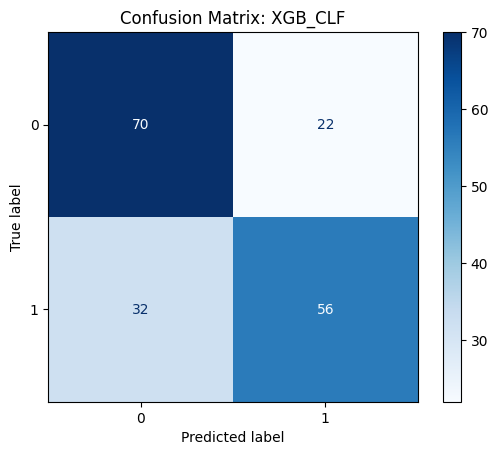

In [57]:
print("Predicting on Test set...")

y_pred_proba = log_reg.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba > 0.45).astype(int)

# Final Metrics
print("\n--- Final Test Set Performance ---")
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["0", "1"])
disp.plot(cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix: {'XGB_CLF'}")
plt.show()

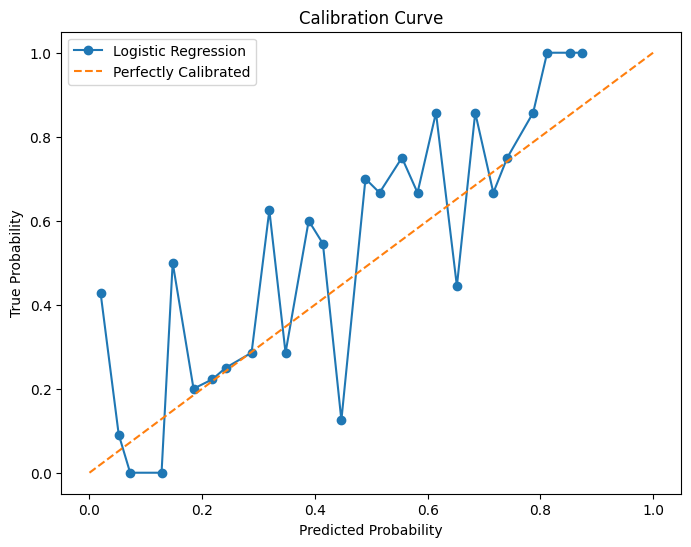

In [58]:
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(
    y_test,
    log_reg.predict_proba(X_test)[:,1],
    n_bins=30
)

plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Logistic Regression')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated')
plt.title('Calibration Curve')
plt.xlabel('Predicted Probability')
plt.ylabel('True Probability')
plt.legend()
plt.show()



In [59]:
import joblib

X=df[features]
y=df['home_team_win']

log_reg_full = Pipeline([
    ('preprocessor', preprocessor),
    ('log_reg', LogisticRegression())
])
log_reg_full.fit(X, y)

c:\Users\James\miniconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['home_past_knockouts',
                                                   'away_past_knockouts',
                                                   'group_stage',
                                                   'knockout_stage',
                                                   'win_rate_diff',
                                                   'experience_diff',
                                                   'goal_diff_diff',
                                                   'wc_experience_diff',
                                                   'elo_diff', 'year',
                                                   'home_past_titles',
                                                   'ho...
                                                   'away_past_semis',
                                                   'home_win_rate',
                                                   'away_win_rate',
                                                   'home_avg_goal_diff',
                                                   'away_avg_goal_diff',
                                                   'home_elo', 'away_elo']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['stage_name',
                                                   'home_confederation_id',
                                                   'away_confederation_id'])])),
                ('log_reg', LogisticRegression())])

In [60]:
import pandas as pd
import joblib

print("Generating final feature snapshots...")

# 1. CREATE A LONG-FORM DATAFRAME
# We add 'home_elo' and 'away_elo' to the columns we extract
cols_home = [
    'match_date', 'home_team_id', 'home_team_win', 'home_team_score', 'away_team_score', 
    'knockout_stage', 'tournament_id',
    'home_past_titles', 'home_past_finals', 'home_past_semis', 'home_years_since_top4',
    'home_elo' # <--- Added
]

# Map to generic names (home_elo -> elo)
cols_generic = [
    'date', 'team_id', 'win', 'score_for', 'score_against', 
    'is_knockout', 'tournament',
    'past_titles', 'past_finals', 'past_semis', 'years_since_top4',
    'elo' # <--- Added
]

home_stats = df[cols_home].copy()
home_stats.columns = cols_generic

cols_away = [
    'match_date', 'away_team_id', 'away_team_win', 'home_team_score', 'away_team_score', 
    'knockout_stage', 'tournament_id',
    'away_past_titles', 'away_past_finals', 'away_past_semis', 'away_years_since_top4',
    'away_elo' # <--- Added
]

away_stats = df[cols_away].copy()
away_stats.columns = cols_generic # Map to same generic names

# Combine
all_stats = pd.concat([home_stats, away_stats]).sort_values('date')

# 2. CALCULATE CUMULATIVE STATS
all_stats['matches_played'] = all_stats.groupby('team_id').cumcount() + 1
all_stats['cumulative_wins'] = all_stats.groupby('team_id')['win'].cumsum()
all_stats['win_rate'] = all_stats['cumulative_wins'] / all_stats['matches_played']

# Avg Goal Diff
all_stats['goal_diff'] = all_stats['score_for'] - all_stats['score_against']
all_stats['matches_played_before'] = all_stats.groupby('team_id').cumcount()
all_stats['goal_diff_before_cum'] = all_stats.groupby('team_id')['goal_diff'].transform(lambda x: x.shift(1).cumsum()).fillna(0)
all_stats['avg_goal_diff'] = all_stats['goal_diff_before_cum'] / all_stats['matches_played_before'].replace(0, pd.NA)
all_stats['avg_goal_diff'] = all_stats['avg_goal_diff'].fillna(0)

# Drop helpers
all_stats.drop(['matches_played_before', 'goal_diff_before_cum'], axis=1, inplace=True)

# Experience & Knockouts
all_stats['wc_experience'] = all_stats['matches_played']
all_stats['is_knockout_appearance'] = all_stats['is_knockout'] 
all_stats['cumulative_knockouts'] = all_stats.groupby('team_id')['is_knockout_appearance'].cumsum()

# 3. EXTRACT LATEST VALUES
latest_stats = all_stats.sort_values('date').groupby('team_id', as_index=True).last()

# Fill Missing Values
features_to_check = ['win_rate', 'avg_goal_diff', 'matches_played', 'wc_experience', 'cumulative_knockouts', 'past_titles', 'past_finals', 'past_semis', 'elo']
for col in features_to_check:
    if col not in latest_stats.columns:
        latest_stats[col] = 0
if 'years_since_top4' not in latest_stats.columns:
    latest_stats['years_since_top4'] = 100
latest_stats['years_since_top4'] = latest_stats['years_since_top4'].fillna(100)

# 4. PREPARE DICTIONARIES
# Create Confederation Map
confed_map_home = df.set_index('home_team_id')['home_confederation_id'].to_dict()
confed_map_away = df.set_index('away_team_id')['away_confederation_id'].to_dict()
team_id_to_confed = {**confed_map_home, **confed_map_away}

features_dict = {
    # Stats calculated in step 2
    'win_rate': latest_stats['win_rate'].to_dict(),
    'avg_goal_diff': latest_stats['avg_goal_diff'].to_dict(),
    'experience': latest_stats['matches_played'].to_dict(),
    'wc_experience': latest_stats['wc_experience'].to_dict(),
    'knockouts': latest_stats['cumulative_knockouts'].to_dict(),
    
    # Elo (Now taken directly from DataFrame)
    'elo': latest_stats['elo'].to_dict(),
    
    # Static/History Stats
    'confederation': team_id_to_confed,
    'past_titles': latest_stats['past_titles'].to_dict(),
    'past_finals': latest_stats['past_finals'].to_dict(),
    'past_semis': latest_stats['past_semis'].to_dict(),
    'years_since_top4': latest_stats['years_since_top4'].to_dict()
}

# Save
joblib.dump(features_dict, 'world_cup_features.pkl')
joblib.dump(log_reg_full, 'world_cup_model.pkl')

print("Success! Features saved including Elo, Win Rate, and Goal Diff.")

Generating final feature snapshots...
Success! Features saved including Elo, Win Rate, and Goal Diff.
